# Contenuti
- [Import delle librerie di base](#Import-delle-librerie-di-base)
- [Dataset](#Dataset)
- [Mobile Net](#Mobile-Net)
- [Fine Tuning vs Addestramento da zero](#Fine-Tuning-vs-Addestramento-da-zero)
- [Creazione del grafo](#Creazione-del-grafo)
- [Resizing e Suddivisione in Training e Validation Set](#Resizing-e-Suddivisione-in-Training-e-Validation-Set)
- [Creazione del Dataset TF 2.x](#Creazione-del-Dataset-TF-2.x)
    - [Suddivisione in minibatch](#Suddivisione-in-minibatch)
- [Addestramento](#Addestramento)
    - [Salvataggio del modello migliore](#Salvataggio-del-modello-migliore)
- [Esercizio](#Esercizio)
    - [Test](#Test)
    - [Visualizzazione errori](#Visualizzazione-errori)
    - [Competizione](#Competizione)

# Esercitazione 8
Nell'esercitazione odierna utilizzeremo le **Convolutional Neural Network** (CNN) per la Classificazione di Animali Domestici.

Differentemente dalle esercitazioni precedenti utilizzeremo come *feature* i *pixel*, ovvero le immagini *raw* in formato RGB.

Faremo uso del framework **TensorFlow** nella sua versione 2.x sfruttando l'API di alto livello **Keras** che semplifica la definizione di CNN profonde e rende disponibili numerosi modelli di reti pre-addestrate su *ImageNet*.

# Import delle librerie di base
Per prima cosa è necessario eseguire l'import delle librerie di base utilizzate durante l'esercitazione. 

In [78]:
%matplotlib inline
import time, os, sys
import math
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from sklearn.model_selection import train_test_split
from pathlib import Path
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nasconde messaggi di debug
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # Rende visibile solo la GPU 0
import tensorflow as tf
print('Tensorflow Version', tf.__version__)

import ml_visualization
import ml_utilities

Tensorflow Version 2.20.0


# Dataset

In questa esercitazione useremo un dataset composto di immagini di cani e gatti. Il dataset è stato raccolto da studenti di questo corso e potrà essere utilizzato per risovere sia il problema binario (*ml\_bin*), sia per il problema multiclasse (*ml\_multi*) avendo a disposizione numerose immagini di ciascun animale.

Per caricare il dataset è necessario impostare:
- il percorso in cui sono memorizzate le immagini del dataset (**db_path**);
- il percorso di una cartella di lavoro (**exp_path**) dove, durante l'elaborazione, saranno memorizzati i file intermedi;
- il percorso di una cartella (**checkpoints_path**) dove saranno memorizzati i modelli addestrati;
- il percorso del file contenente la lista delle immagini e relative etichette di classe da utilizzare come *training set* (**train_filelist**);
- il percorso del file contenente la lista delle immagini e relative etichette di classe da utilizzare come *test set* (**test_filelist**);
- il percorso del file contenente la lista dei nomi delle classi (**label_filelist**).

Di seguito sono rese disponibili le tre configurazioni utilizzate durante l'esercitazione.

In [79]:
db_name = 'ml_bin' # 'ml_bin' 'ml_multi'

if db_name == 'ml_bin':
    db_path = 'DBs/CaniGatti_ML18_Es8_2020' 
    train_filelist = 'BinaryTrainingSet.txt'
    test_filelist = 'BinaryTestSet.txt'
    label_filelist = db_path + '/BinaryLabels.txt'
    class_num = 2   # caso 2 classi
    validation_size = 200
    test_has_labels = True
elif db_name == 'ml_multi':
    db_path = 'DBs/CaniGatti_ML18_Es8_2020'
    train_filelist = 'MulticlassTrainingSet.txt'
    test_filelist = 'MulticlassTestSet.txt'
    label_filelist = db_path + '/MulticlassLabels.txt'
    class_num = 12   # caso 12 classi - singoli animali
    validation_size = 200
    test_has_labels = False
else:
    raise ValueError('Database non valido.')

checkpoints_path = './saved_models'
exp_path = './exp_cache'

# Predisposizione di un'area di caching su disco che velocizza la riesecuzione di chiamate di funzioni con gli stessi parametri
memory = Memory(exp_path, verbose=0)  

# Caricamento delle immagini
print('Caricamento in corso ...')
start = time.time()
raw_images_x, label_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)

# Carica le etichette di classe
label_names = [line.rstrip('\n') for line in open(label_filelist,'r')]

print('Caricate %d immagini in %.2f s.' % (len(raw_images_x), time.time() - start))
for i in range(len(label_names)):
    print('{}: {}'.format(label_names[i], np.count_nonzero(label_y == i)))

Caricamento in corso ...
Caricate 650 immagini in 0.79 s.
Gatto: 367
Cane: 283


# Mobile Net

Il modello di CNN (o meglio la famiglia di modelli di CNN) che utilizzeremo in questa esercitazione è noto come [**MobileNet V1**](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNet). Si tratta di un'architettura proposta da Google che garantisce performance di tutto rispetto (equiparabili a una GoogleNet) a un ragionevole costo computazionale, il che la rende particolarmente idonea ad operare in *inference* anche su architetture leggere (prive di GPU), come smartphone Android o iOS.

A seconda del budget computazionale a disposizione, al modello base si può applicare:
- un *resolution multiplier* che determina una riduzione sulla dimensione dell'immagine di input. Default = 224. Valori possibili: [224, 192, 160, 128] 
- un *depth multiplier* che opera una riduzione del numero di feature maps (canali) nei diversi layer, pari a una frazione di quelli del modello base. Default = 1. Valori possibili [1, 0.75, 0.50. 0.25]

Per le piattaforme embedded sono disponibili anche versioni con quantizzazione *eight-bit fixed point* che riduce 4 volte l'occupazione di memoria rispetto a floting point 32 bit.

*Keras* mette a disposizione funzioni semplificate per la creazione del grafo di MobileNet dati i moltiplicatori (resolution e depth). L'immagine di seguito mostra l'architettura della MobileNet V1 con depth e resolution multipliers impostati ai valori di default (1.0 e 224 rispettivamente).

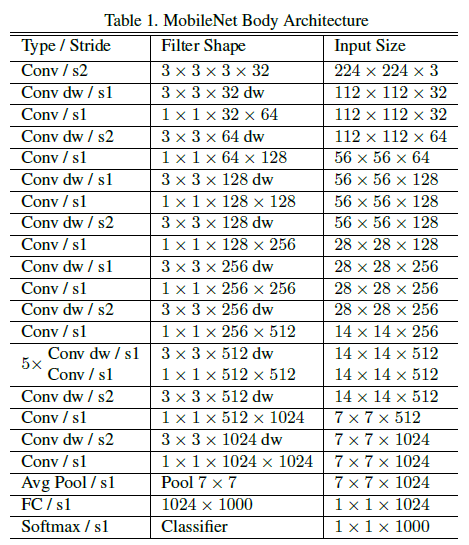

# Fine Tuning vs Addestramento da zero

Un modello profondo e complesso come una MobileNet (28 layers, 4.2M parametri) non può essere efficacemente addestrato da zero (ovvero a partire da pesi casuali) utilizzando poche decine di migliaia di immagini.

Infatti, specialmente per i livelli molto lontani dall'output che fungono come *feature extractors* iniziali, sono necessarie molte epoche su dataset con centinaia di migliaia di esempi.

Possiamo però partire da un modello preaddestrato su ImageNet (caricandone i pesi) e modificandoli in base al training supervisionato del nostro problema. Questo approccio è noto come **Fine Tuning**.

Bisogna però fare attenzione al fatto che il grafo originale del modello deve essere modificato, rimpiazzando il livello di output (*logit layer*) che originariamente aveva 1001 classi (le 1000 di ImageNet + 1 per la classe sconosciuta), in un nuovo livello di output con tanti neuroni quante sono le nuove classi. Solo per questo nuovo livello i pesi dovranno essere reinizializzati in modo casuale.

# Creazione del grafo

Vediamo ora come creare il grafo del modello e adattarlo per il Fine Tuning, con il supporto dell'API funzionale offerta da Keras.

Nella seguente cella viene caricata la rete MobileNet con i pesi preaddestrati sul dataset ImageNet, viene definita la *loss* e l'ottimizzatore da utilizzare così come le principali metriche di classificazione. Si noti che la rete viene creata con il parametro *include\_top* impostato a *False*. Questo significa che viene restituito un modello privato dell'ultimo layer della rete (che altrimenti presenterebbe 1000+1 output, pari al numero di classi in ImageNet).

Il layer finale viene creato e agganciato nelle righe di codice immediatamente successive in modo da utilizzare un layer con tanti neuroni quante sono le classi del problema da risolvere.

Infine vengono definite le funzioni che verranno utilizzate per svolgere i passi di addestramento e test.

In [80]:
mobilenet_version = 'small'  # 'small' 'default'

if mobilenet_version == 'default':
    image_side = 224
    width_multiplier = 1.0
elif mobilenet_version == 'small':
    image_side = 128
    width_multiplier = 0.5
else:
    raise ValueError('Versione di MobileNet non supportata.')

# Definizione della shape dei tensori delle immagini
IMG_SHAPE = (image_side, image_side, 3)

# Creazione della rete
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             alpha=width_multiplier, 
                                             include_top=False,
                                             pooling='avg',
                                             weights='imagenet')

# Se trainable è uguale a False i pesi della rete sono congelati
# In questo caso vogliamo permettere l'addestramento dei pesi
base_model.trainable = True

# Definisce la loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Definisce l'ottimizzatore
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0025)

# Le metriche offerte da Keras accumulano i valori su più batch
# Loss media sul training set
train_loss = tf.keras.metrics.Mean(name='train_loss')  
# Accuratezza sul training set
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')  

# Loss media sul validation/test set
val_loss = tf.keras.metrics.Mean(name='val_loss')
# Accuratezza sul validation/test set
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# Adatta la rete usando Functional API di Keras
inputs = tf.keras.Input(shape=IMG_SHAPE)
feature = base_model(inputs)
dense_layer = tf.keras.layers.Dense(class_num)
logits = dense_layer(feature)
softmax_layer = tf.keras.layers.Softmax()
probs = softmax_layer(logits)
model = tf.keras.Model(inputs=inputs, outputs=[logits, probs])

# NOTA: non viene chiamata la funzione .compile di Keras in
# quanto eseguiamo il training a più basso livello senza 
# utilizzare la funzione .fit

# Funzione di train su un minibatch (iterazione)
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits, _ = model(images, training=True)
        loss = loss_object(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # Le metriche accumulano i valori (fino a chiamata di reset)
    train_loss(loss)
    train_accuracy(labels, logits)

# Funzione di inference su un minibatch    
@tf.function
def test_step(images, labels):
    logits, probs = model(images, training=False)
    v_loss = loss_object(labels, logits)
    # Le metriche accumulano i valori (fino a chiamata di reset)
    val_loss(v_loss)
    val_accuracy(labels, logits) 
    return probs

È possibile visualizzare il modello risultante delle operazioni di caricamento e modifica della rete utilizzando il metodo **.summary()**.

In [81]:
# base_model.summary()  # Modello prima delle modifiche

model.summary()
# tf.keras.utils.plot_model(model, 'mymodel.png', show_shapes=True) # Richiede pydot e graphviz, opzionale

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_0.50_128 (Functional) │ (None, 512)            │       829,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │         1,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_20 (Softmax)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,562 (3.17 MB)

 Trainable params: 819,618 (3.13 MB)

 Non-trainable params: 10,944 (42.75 KB)

# Resizing e Suddivisione in Training e Validation Set

Ora che è stato definito il modello da utilizzare è possibile processare il dataset per portare le immagini alla dimensione desiderata (*image\_side*) e per ottenere un validation set separato. La cella seguente mostra come suddividere il dataset in training e validation set utilizzando [**train_test_split**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) mentre il ridimensionamento delle immagini è affidato alla funzione *resize\_images* già vista nelle precedenti esercitazioni.

In [82]:
print('Resizing in corso ...')
start = time.time()
resized_image_x = ml_utilities.resize_images(raw_images_x, image_side, image_side, cache=memory)
print('Resizing completato in %.2f s.' % (time.time() - start))

train_x, validation_x, train_y, validation_y = train_test_split(resized_image_x, label_y,
                                                                test_size=validation_size,
                                                                stratify=label_y,
                                                                random_state=1234)

print('Numero di pattern nel training set:', len(train_x))
print('Numero di pattern nel validation set:', len(validation_x))

Resizing in corso ...
Resizing completato in 0.96 s.
Numero di pattern nel training set: 450
Numero di pattern nel validation set: 200


# Creazione del Dataset TF 2.x

TensorFlow mette a disposizione la classe [**Dataset**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) in grado di semplificare diverse operazioni di caricamento e manipolazione del dataset. Uno dei metodi più semplici per create un Dataset di TensorFlow è quello di utilizzare la funzione [**from\_tensor\_slices**](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) che trasforma dei tensori NumPy in un Dataset dal medesimo contenuto.

In [83]:
training_set = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_set = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))

## Suddivisione in minibatch

Una volta applicate le procedure di caricamento, di augmentation e finalizzata la suddivisione di training e validation set è possibile, grazie alle funzionalità della classe Dataset, definire la suddivisione in minibatch.

La cella seguente mostra come utilizzare il metodo **.batch(...)** per ottenere un dataset che resituirà un numero di pattern pari a *minibatch\_size* a ogni iterazione. I Dataset di TensorFlow infatti, se non configurati diversamente, restituiscono singoli pattern.

I dataset *train\_dataset* e *valid\_dataset* creati nella seguente cella resituiranno a ogni iterazione un numero di pattern pari a *minibatch\_size*. Le immagini contenute in ogni minibatch verranno unite in un unico tensore di dimensione *(minibatch\_size, image\_side, image\_side, 3)*.

In [84]:
minibatch_size = 50

train_dataset = training_set.batch(minibatch_size, drop_remainder=True) 
valid_dataset = validation_set.batch(minibatch_size, drop_remainder=True)

# Addestramento
Ora siamo pronti per il *training*. La cella seguente esegue l'addestramento della MobileNet per un numero di epoche pari a **n_epochs** utilizzando minibatch di dimensione **minibatch_size**.

Start Training
Epoch 1  .........++++  Train loss: 0.9188  Train acc: 51.56 %  Validation acc: 60.00 %
Epoch 2  .........++++  Train loss: 0.5004  Train acc: 74.67 %  Validation acc: 75.00 %
Salvataggio del modello...
 -> 900 patterns (19.88 sec.) -> 45.27 patt/sec


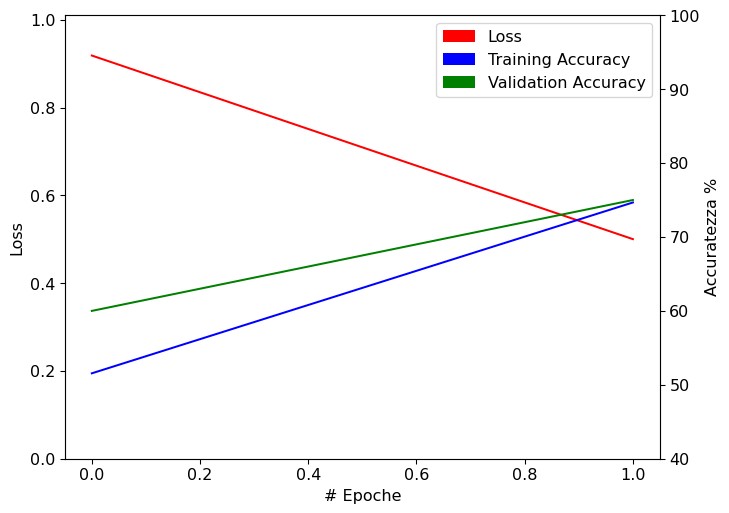

In [85]:
# Attenzione: eseguire questa cella più volte significa riprendere
# l'addestramento da dove era stato lasciato, cioè non ricomincia
# ogni volta dai pesi iniziali!
n_epochs = 2
   
epochs_training_loss = []
epochs_validation_accuracy = []
epochs_training_accuracy = []

t_start = time.time()
print("Start Training")

total_train_patterns = 0

for epoch in range(n_epochs):

    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()
    
    print("Epoch", epoch + 1, " ", end="")
    
    # Train su tutti i minibatch dell'epoca
    for X_minibatch, y_minibatch in train_dataset:
        total_train_patterns += len(X_minibatch)
        print(".", end="", flush = True)
        train_step(X_minibatch, y_minibatch)  
    
    # Evaluation
    for X_minibatch, y_minibatch in valid_dataset:
        print("+", end="", flush = True)
        test_step(X_minibatch, y_minibatch)
        
    epochs_training_loss.append(train_loss.result().numpy())
    epochs_training_accuracy.append(train_accuracy.result().numpy() * 100)
    epochs_validation_accuracy.append(val_accuracy.result().numpy() * 100)

    print("  Train loss: %.4f  Train acc: %.2f %%  Validation acc: %.2f %%" % (train_loss.result(), train_accuracy.result() * 100, val_accuracy.result() * 100))

print('Salvataggio del modello...')
# Salva tutto: pesi, ottimizzatore, ecc.
save_path = str(Path(checkpoints_path) / ("dogcat_model_%s_with_%d_classes.keras" % (db_name, class_num)))
model.save(save_path)

t_elapsed = time.time()-t_start
print (' -> %d patterns (%.2f sec.) -> %.2f patt/sec' % (total_train_patterns, t_elapsed, total_train_patterns / t_elapsed))

ml_visualization.plot_performance_curves(epochs_training_loss, epochs_training_accuracy, epochs_validation_accuracy)

La cella seguente mostra come costruire la *Confusion Matrix* per il validation set. Il codice della cella seguente mostra come eseguire un'epoca sul validation set memorizzandone i risultati. I risultati vengono successivamente utilizzati per disegnare la matrice.

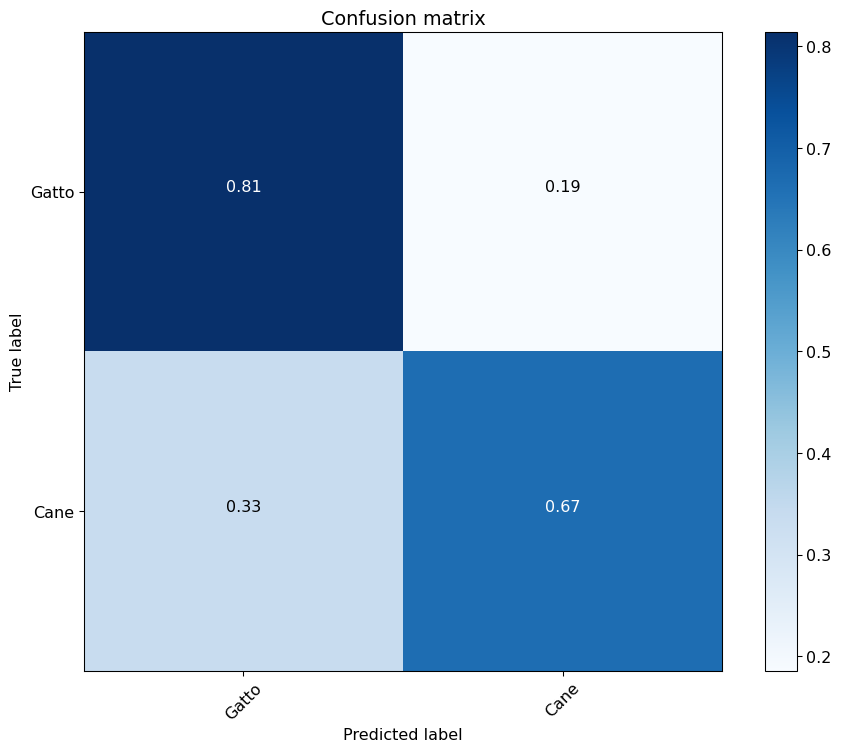

In [86]:
first_minibatch = True
for X_minibatch, y_minibatch in valid_dataset:
    minibatch_probs = test_step(X_minibatch, y_minibatch)
    if first_minibatch:
        valid_probs = minibatch_probs.numpy()
        first_minibatch = False
    else:
        valid_probs = np.concatenate((valid_probs, minibatch_probs))

# argmax permette di ottenere l'etichetta di classe con 
# punteggio più alto per tutti i pattern
predicted_y = valid_probs.argmax(axis=1)
ml_visualization.plot_confusion_matrix(validation_y, predicted_y, label_names, figsize=(10,8))


# Tuning degli iperparametri

Per il solo problema binario si provi a intervenire sugli iperparametri nel seguente ordine:
- aumentare/diminuire il numero di epoche (**n_epochs**) per garantire convergenza evitando al tempo stesso overfitting;
- tarare il *learning rate* (**learning_rate** nella sezione [Creazione del grafo](#Creazione-del-grafo));
- provare un diverso Optimizer (es. [**Adam**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) nella sezione [Creazione del grafo](#Creazione-del-grafo));


## Salvataggio del modello migliore
Si consiglia di modificare il codice della cella precedente per poter salvare ad ogni epoca il modello ottenuto (solamente se l'accuratezza di validation è maggiore della massima incontrata fino a quel momento). In questo modo alla fine della fase di *train* il modello salvato sarà il migliore anche se avete impostato un numero di epoche maggiore di quello ottimale.

NOTA: il modello viene salvato con un nome diverso a seconda del tipo di problema affrontato (binario, multiclasse).

## Test

Per il problema binario sono fornite le etichette di classe per il test set. la seguente cella misura l'accuratezza della miglior soluzione ottenuta (utilizzando il modello salvato al passo precedente) sul dataset di test per verificarne l'effettiva capacità di generalizzazione.

Computing Accuracy on the Test Set  77.25 %
 -> 400 patterns (1.57 sec.) -> 254.84 patt/sec
(400,) (400,)


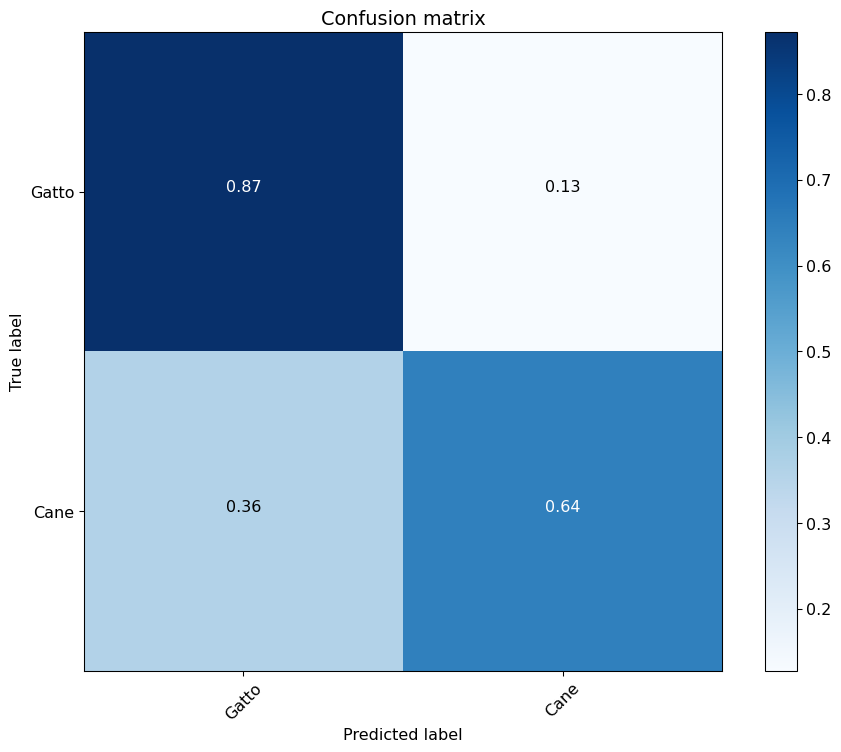

In [87]:
minibatch_size_test = 50

if not test_has_labels:
    # Non sono fornite etichette per il problema di classificazione sui singoli animali
    raise ValueError('Il test set per il problema scelto non ha etichette di classe')
    
raw_test_images_x, test_y = ml_utilities.load_labeled_dataset(test_filelist, db_path, cache=memory)
resized_test_image_x = ml_utilities.resize_images(raw_test_images_x, image_side, image_side, cache=memory)

test_dataset = tf.data.Dataset.from_tensor_slices((resized_test_image_x, test_y))
test_dataset = test_dataset.batch(minibatch_size_test, drop_remainder=False)

# Carica il modello salvato in precedenza su disco.
# Attenzione: se questa istruzione restituisce un errore
# è possibile commentarla e utilizzare il modello
# già memorizzato nella variabile "model". In alternativa
# è possibile aggiornare a TensorFlow 2.2.0 o superiore.
model = tf.keras.models.load_model(save_path)

print("Computing Accuracy on the Test Set ", end="" )
t_start = time.time()

# Riutilizziamo gli oggetti metrics usati per il validation set
val_loss.reset_state()
val_accuracy.reset_state()

first_minibatch = True
for X_minibatch, y_minibatch in test_dataset:
    minibatch_probs = test_step(X_minibatch, y_minibatch)
    if first_minibatch:
        test_probs = minibatch_probs.numpy()
        first_minibatch = False
    else:
        test_probs = np.concatenate((test_probs, minibatch_probs))
        
print(" %.2f %%" % (100 * val_accuracy.result()))
t_elapsed = time.time()-t_start
print (' -> %d patterns (%.2f sec.) -> %.2f patt/sec' % (len(test_y), t_elapsed, len(test_y) / t_elapsed))

predicted_y = test_probs.argmax(axis=1)
print(predicted_y.shape, test_y.shape)
ml_visualization.plot_confusion_matrix(test_y, predicted_y, label_names, figsize=(10,8))

## Visualizzazione errori
La cella seguente permette di visualizzare le immagini di test che la rete classifica erroneamente. Sopra ad ogni immagine è riportato il nome della classe corretta mentre a lato le classi più probabili.

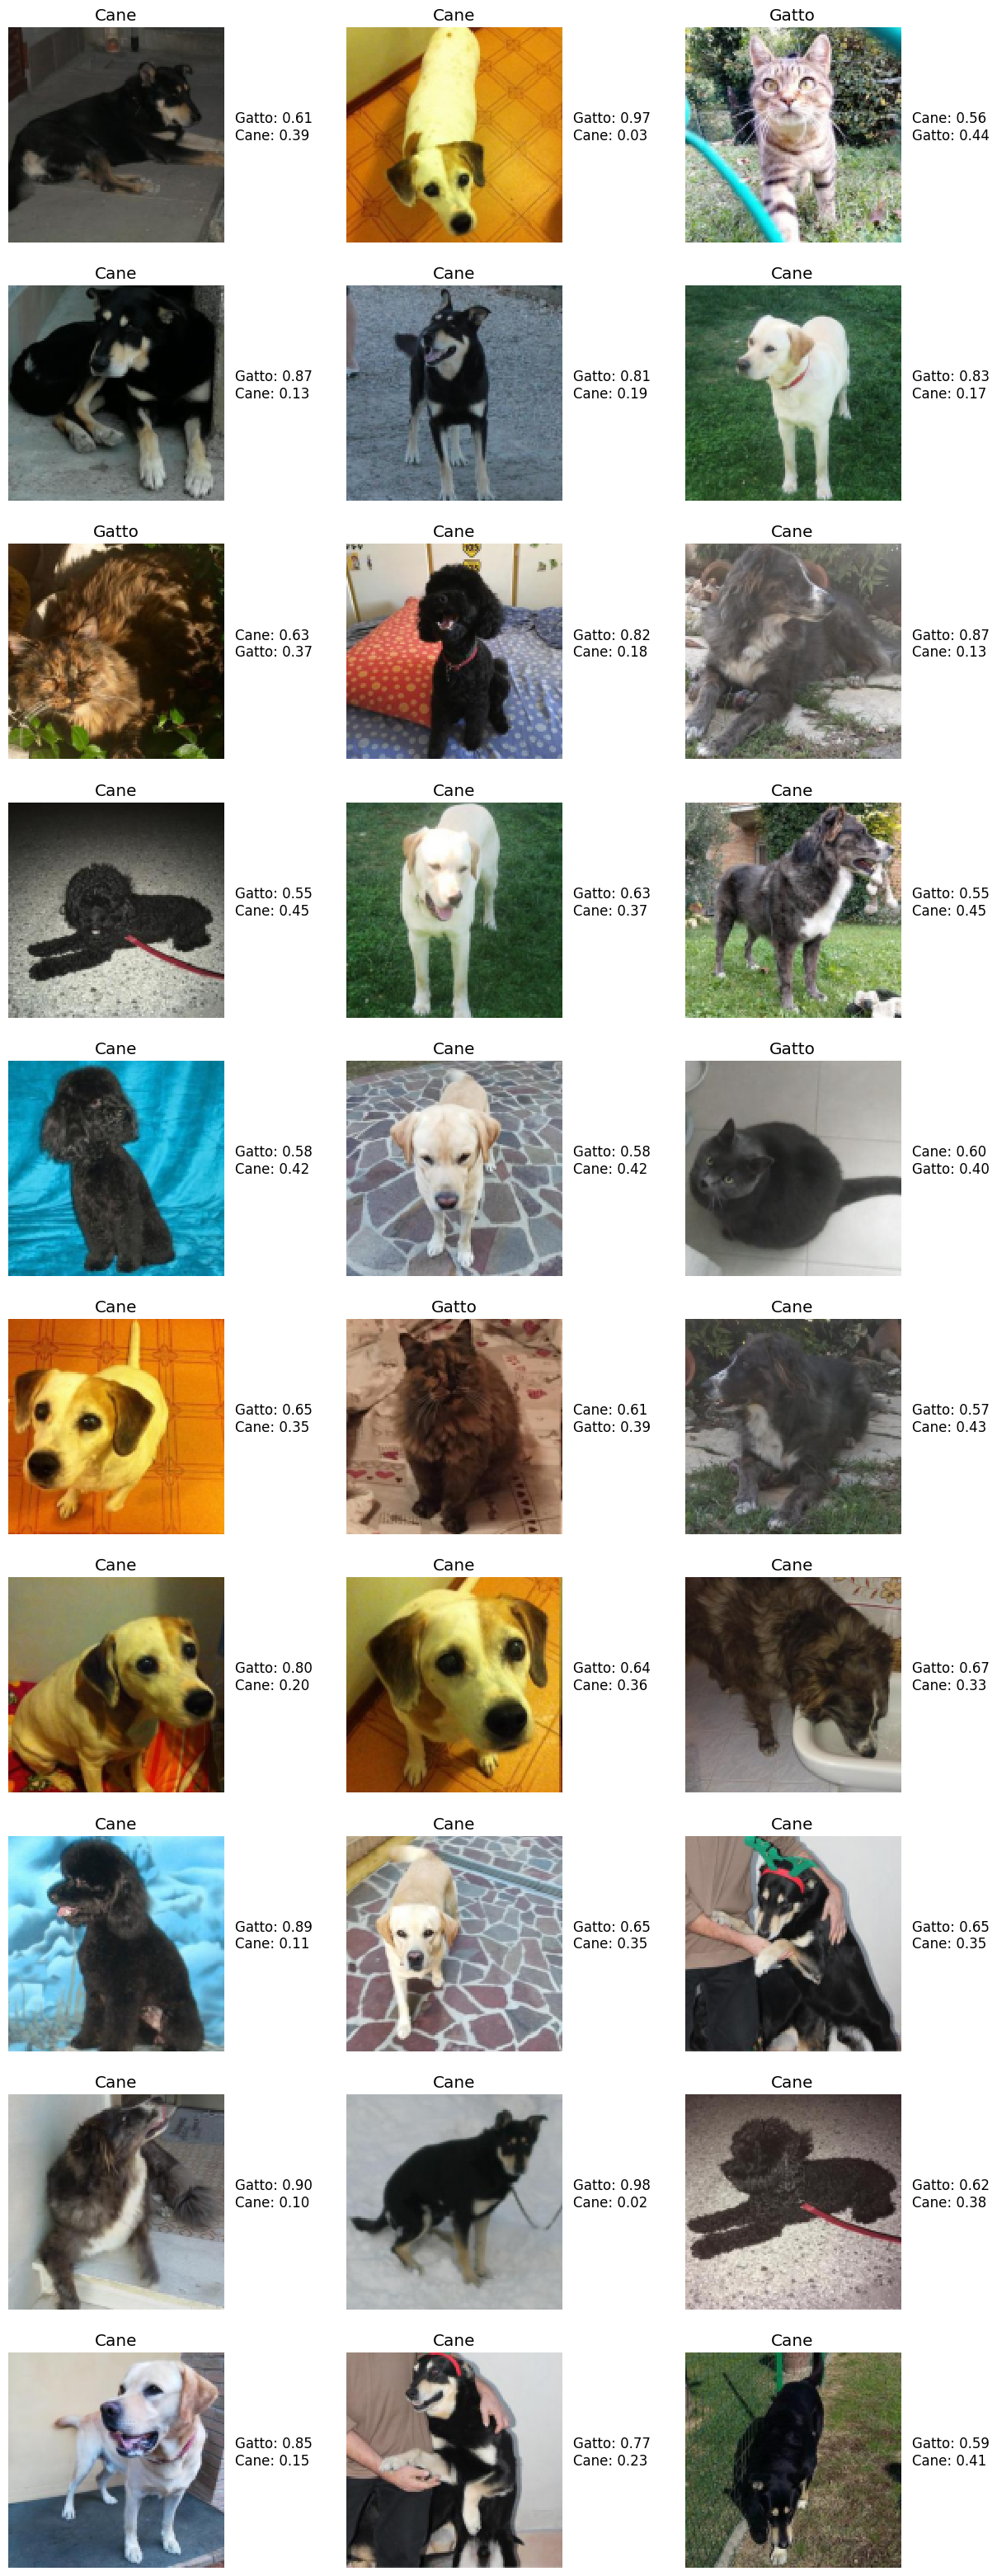

In [88]:
errors = predicted_y != test_y
error_idx = np.where(errors == True)[0]

# Visualizzazione immagini
image_per_row = min(3, len(error_idx))
top_class_count = 3
max_images = min(30, len(error_idx))

row_count = math.ceil(max_images / image_per_row)
column_count = image_per_row
plt.rcParams.update({'font.size': 12})
_, axs = plt.subplots(row_count, column_count, figsize=(15, 4*row_count), squeeze=False)

for i in range(row_count):
    for j in range(column_count):
        axs[i,j].axis('off')

for i in range(max_images):
    q = i//image_per_row
    r = i%image_per_row
    idx = error_idx[i]
    axs[q,r].imshow(resized_test_image_x[idx])
    axs[q,r].set_title(label_names[test_y[idx]])
    
    sorted_test_probs, sorted_label_names= (list(t) for t in zip(*sorted(zip(test_probs[idx], label_names))))
    text=''
    for j in range(min(top_class_count,class_num)):
        text+='{}: {:.2f}\n'.format(sorted_label_names[-j-1],sorted_test_probs[-j-1])
    
    axs[q,r].text(resized_test_image_x[idx].shape[1]*1.05, resized_test_image_x[idx].shape[0]*0.5, text, horizontalalignment='left', verticalalignment='center')
plt.show()

In [ ]:
db_path = 'DBs/CaniGatti_ML18_Es8_2020'
train_filelist = 'MulticlassTrainingSet.txt'
test_filelist = 'MulticlassTestSet.txt'
label_filelist = db_path + '/MulticlassLabels.txt'

## Competizione

Per il problema multi-classe non sono fornite etichette di classe. L'obiettivo è quello di massimizzare l'accuratezza di classificazione sul dataset di test di questo problema. Ai fini della competizione si ignori il problema binario.

Il dataset di test contiene gli stessi pattern del dataset del problema binario. Tuttavia il problema da risolvere è differente: si tratta di un problema di classificazione con 12 classi in cui si richede di addestrare un classificatore in grado di individuare quale specifico animale è ritratto nelle diverse immagini.

- Si consiglia di utilizzare tutte le conoscenze accumulate durante il corso, in particolare quelle sull'esercitazione MLP;
- **Non è possibile modificare l'architettura della rete base (MobileNet v1)** ma è possibile modificare il/i livelli aggiunti nella parte finale della rete e i loro iperparametri;
- È possibile tarare la dimensione del minibatch, il numero di epoche, il learning rate e modificare l'ottimizzatore (e i relativi iperparametri) utilizzando uno di quelli disponibili in Keras ([qui la lista](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers));
- È possibile utilizzare **uno *scheduler* del Learning Rate** tra quelli disponilibi in Keras ([qui la lista completa](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)). Nella documentazione dei vari scheduler sono presenti semplici esempi che mostrano come utilizzarli;
- È possibile utilizzare la rete MobileNet V1 sia con i pesi pre-addestrati su ImageNet sia con pesi inizializzati casualmente;
- È possibile utilizzare uno schema di addestramento in cui solo alcuni dei layer vengono addestrati in momenti differenti (vedi parametro base_model.trainable per attivare o meno la modifica dei pesi nella parte bassa del modello);
- IMPORTANTE: è possibile estendere le immagini del training set implementando una procedura di **data augmentation** che aggiunge varianti (ad esempio con cambiamenti di scala, rotazione, traslazione, luminosità). Per farlo si consiglia di fare riferimento alla [guida ufficiale](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=en#apply_augmentation_to_a_dataset) di TensorFlow. In alternativa è possibile applicare l'augmentation direttamente sulle immagini memorizzate in formato NumPy prima della creazione dei Dataset di TF 2.x.

Ai fini dell'esercizio (e della competizione) valgono le seguenti regole:

- **Deve essere utilizzata la rete nella sua versione "small"**, ovvero con *resolution* pari a 128 e un *width multiplier* di 0.5;
- Non è possibile modificare il modello della rete base (parte bassa) o utilizzare una rete differente;

Si addestri il modello desiderato utilizzando la configurazione trovata nell'esercizio precedente. Il codice contenuto nella cella seguente userà tale modello per predire la classe dei pattern del dataset di test. Le classi predette verranno salvate su un file di testo che dovrà essere caricato sul sito della competizione per misurarne l'accuratezza.
Le procedure utilizzate per caricare i dataset e per addestrare il modello dovranno essere riportate nella cella seguente. Ai fini della competizione si ricorda che nel file .zip dovrà essere inclusa anche una cartella "Codice" contenente una copia di questo notebook e degli script Python utilizzati.

Caricamento training set in corso ...
Caricate 650 immagini in 0.33 s.
Resizing training set in corso ...
Resizing completato in 0.45 s.
Start Training (Adamax + Dropout)...
Epoch 1  ......... Train acc: 64.22 % Val acc: 47.00 %
Epoch 2  ......... Train acc: 97.33 % Val acc: 43.50 %
Epoch 3  ......... Train acc: 99.78 % Val acc: 44.00 %
Epoch 4  ......... Train acc: 99.78 % Val acc: 51.00 %
Epoch 5  ......... Train acc: 99.78 % Val acc: 58.00 %
Epoch 6  ......... Train acc: 100.00 % Val acc: 66.50 %
Epoch 7  ......... Train acc: 100.00 % Val acc: 75.00 %
Epoch 8  ......... Train acc: 100.00 % Val acc: 79.00 %
Epoch 9  ......... Train acc: 100.00 % Val acc: 84.00 %
Epoch 10  ......... Train acc: 100.00 % Val acc: 84.50 %
Epoch 11  ......... Train acc: 100.00 % Val acc: 86.00 %
Epoch 12  ......... Train acc: 100.00 % Val acc: 88.50 %
Epoch 13  ......... Train acc: 100.00 % Val acc: 89.50 %
Epoch 14  ......... Train acc: 100.00 % Val acc: 91.00 %
Epoch 15  ......... Train acc: 100.00 % Va

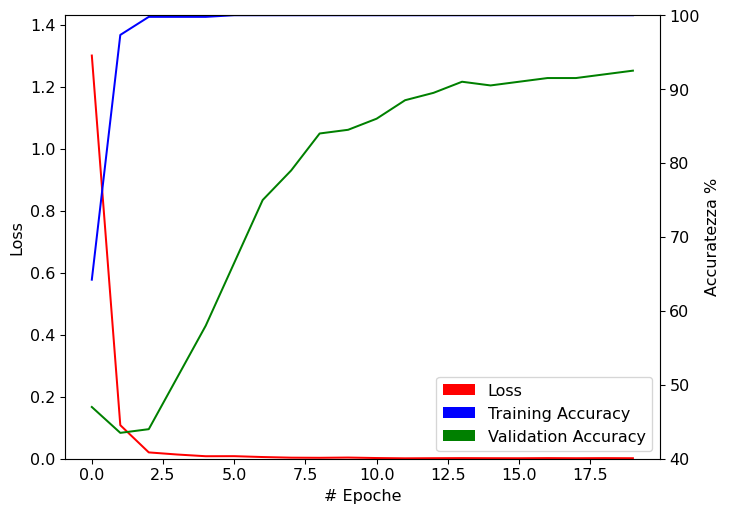


--- Avvio Predizione Competizione ---
File Es8Predictions.txt salvato.


In [92]:
%matplotlib inline
import time, os, sys
import math
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory
from sklearn.model_selection import train_test_split
from pathlib import Path
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import ml_visualization
import ml_utilities

db_path = 'DBs/CaniGatti_ML18_Es8_2020'
train_filelist = 'MulticlassTrainingSet.txt'
test_filelist = 'MulticlassTestSet.txt'
label_filelist = db_path + '/MulticlassLabels.txt'

class_num = 12
validation_size = 200

checkpoints_path = './saved_models'
exp_path = './exp_cache'
memory = Memory(exp_path, verbose=0)

print('Caricamento training set in corso ...')
start = time.time()
raw_images_x, label_y = ml_utilities.load_labeled_dataset(train_filelist, db_path, cache=memory)
label_names = [line.rstrip('\n') for line in open(label_filelist,'r')]
print('Caricate %d immagini in %.2f s.' % (len(raw_images_x), time.time() - start))

mobilenet_version = 'small'
image_side = 128
width_multiplier = 0.5
IMG_SHAPE = (image_side, image_side, 3)

print('Resizing training set in corso ...')
start = time.time()
resized_image_x = ml_utilities.resize_images(raw_images_x, image_side, image_side, cache=memory)
print('Resizing completato in %.2f s.' % (time.time() - start))

train_x, validation_x, train_y, validation_y = train_test_split(
    resized_image_x, label_y,
    test_size=validation_size,
    stratify=label_y,
    random_state=1234
)

minibatch_size = 50
training_set = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_set = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))

train_dataset = training_set.shuffle(1000).batch(minibatch_size, drop_remainder=True)
valid_dataset = validation_set.batch(minibatch_size, drop_remainder=True)

base_model = tf.keras.applications.MobileNet(
    input_shape=IMG_SHAPE,
    alpha=width_multiplier,
    include_top=False,
    pooling='avg',
    weights='imagenet'
)
base_model.trainable = True 

inputs = tf.keras.Input(shape=IMG_SHAPE)
feature = base_model(inputs)
x = tf.keras.layers.Dropout(0.3)(feature)
dense_layer = tf.keras.layers.Dense(class_num)
logits = dense_layer(x)
softmax_layer = tf.keras.layers.Softmax()
probs = softmax_layer(logits)

model = tf.keras.Model(inputs=inputs, outputs=[logits, probs])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits, _ = model(images, training=True)
        loss = loss_object(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, logits)

@tf.function
def test_step(images, labels):
    logits, probs = model(images, training=False)
    v_loss = loss_object(labels, logits)
    val_loss(v_loss)
    val_accuracy(labels, logits)
    return probs

n_epochs = 20
epochs_training_loss = []
epochs_training_accuracy = []
epochs_validation_accuracy = []

print(f"Start Training (Adamax + Dropout)...")
t_start = time.time()

for epoch in range(n_epochs):
    train_loss.reset_state()
    train_accuracy.reset_state()
    val_loss.reset_state()
    val_accuracy.reset_state()

    print("Epoch", epoch + 1, " ", end="")

    for X_minibatch, y_minibatch in train_dataset:
        train_step(X_minibatch, y_minibatch)
        print(".", end="", flush=True)

    for X_minibatch, y_minibatch in valid_dataset:
        test_step(X_minibatch, y_minibatch)

    epochs_training_loss.append(train_loss.result().numpy())
    epochs_training_accuracy.append(train_accuracy.result().numpy() * 100)
    epochs_validation_accuracy.append(val_accuracy.result().numpy() * 100)
    
    print(" Train acc: %.2f %% Val acc: %.2f %%" % 
          (train_accuracy.result() * 100, val_accuracy.result() * 100))

print('Training completato in %.2f s.' % (time.time() - t_start))
ml_visualization.plot_performance_curves(epochs_training_loss, epochs_training_accuracy, epochs_validation_accuracy)

print('\n--- Avvio Predizione Competizione ---')
raw_test_images_x = ml_utilities.load_unlabeled_dataset(test_filelist, db_path, cache=memory)
resized_test_image_x = ml_utilities.resize_images(raw_test_images_x, image_side, image_side, cache=memory)

test_dataset = tf.data.Dataset.from_tensor_slices((resized_test_image_x,))
test_dataset = test_dataset.batch(50, drop_remainder=False)

first_minibatch = True
for X_minibatch in test_dataset:
    if isinstance(X_minibatch, tuple): X_minibatch = X_minibatch[0]
    _, minibatch_probs = model(X_minibatch, training=False)
    
    if first_minibatch:
        valid_probs = minibatch_probs.numpy()
        first_minibatch = False
    else:
        valid_probs = np.concatenate((valid_probs, minibatch_probs))

predicted_y = valid_probs.argmax(axis=1)
np.savetxt('Es8Predictions.txt', predicted_y.astype(int), fmt='%i')
print('File Es8Predictions.txt salvato.')
